In [1]:
import os
import sys
from dotenv import load_dotenv
load_dotenv() 

# Set the target folder name you want to reach
target_folder = "phate-for-text"

# Get the current working directory
current_dir = os.getcwd()

# Loop to move up the directory tree until we reach the target folder
while os.path.basename(current_dir) != target_folder:
    parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
    if parent_dir == current_dir:
        # If we reach the root directory and haven't found the target, exit
        raise FileNotFoundError(f"{target_folder} not found in the directory tree.")
    current_dir = parent_dir

# Change the working directory to the folder where "phate-for-text" is found
os.chdir(current_dir)

# Add the "phate-for-text" directory to sys.path
sys.path.insert(0, current_dir)

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import ipywidgets as widgets
from itertools import cycle
import json
import itertools

In [3]:

embedding ='text-embedding-3-large'

In [4]:
params = [
    {'theme': None, 't': 1.0, 'maxsub': 5, 'depth': 3, 'synonyms': None,'noise': None, '': 'random'},
    {'theme': None, 't': 1.0, 'maxsub': 3, 'depth': 5, 'synonyms': None,'noise': None, '': 'random'},
    # {'theme': None, 't': 1.0, 'maxsub': 5, 'depth': 3, 'synonyms': 10,'noise': None, '': 'random'},
    # {'theme': None, 't': 1.0, 'maxsub': 5, 'depth': 3, 'synonyms': 0,'noise': None, '': 'random'},
    # {'theme': None, 't': 1.0, 'maxsub': 3, 'depth': 5, 'synonyms': 10,'noise': None, '': 'random'},
    # {'theme': None, 't': 1.0, 'maxsub': 3, 'depth': 5, 'synonyms': 0,'noise': None, '': 'random'},
    # {'theme': "Energy, Ecosystems, and Humans", 't': 1.0, 'maxsub': 3, 'depth': 5,'synonyms':10,'noise':0.25,'':'random'},
    # # {'theme': "Energy, Ecosystems, and Humans", 't': 1.0, 'maxsub': 5, 'depth': 3, 'synonyms': None, '': 'random'},
    # {'theme': "Offshore energy impacts on fisheries", 't': 1.0, 'maxsub': 3, 'depth': 5,'synonyms':10,'noise':0.25,'':'random'},
    # # {'theme': "Offshore energy impacts on fisheries", 't': 1.0, 'maxsub': 5, 'depth': 3,'synonyms':10,'noise':0.25,'':'random'},
    # {'theme': "West Java, Indonesia", 't': 1.0, 'maxsub': 3, 'depth': 5, 'synonyms':10,'noise':0.25,'':'random'},
    # # {'theme': "West Java, Indonesia", 't': 1.0, 'maxsub': 5, 'depth': 3, 'synonyms': None, '': 'random'},

    # # Additional entries with noise=0.25
    # {'theme': None, 't': 1.0, 'maxsub': 5, 'depth': 3, 'synonyms': None,'noise': 0.25, '': 'random'},
    # {'theme': None, 't': 1.0, 'maxsub': 3, 'depth': 5, 'synonyms': None,'noise': 0.25, '': 'random'},
    # {'theme': None, 't': 1.0, 'maxsub': 5, 'depth': 3, 'synonyms': None,'noise': 0.0, '': 'random'},
    # {'theme': None, 't': 1.0, 'maxsub': 3, 'depth': 5, 'synonyms': None,'noise': 0.0, '': 'random'},
    # {'theme':None,'t':1.0,'maxsub':3,'depth':5,'synonyms':10,'noise':0.25,'':'random'}
]


# params = [{'theme':None,'t':1.0,'maxsub':3,'depth':5,'synonyms':10,'noise':0.25,'':'random'}]


In [7]:
with open('evaluations/combo_color_map.json', 'r') as file:
    combo_color_map = json.load(file)

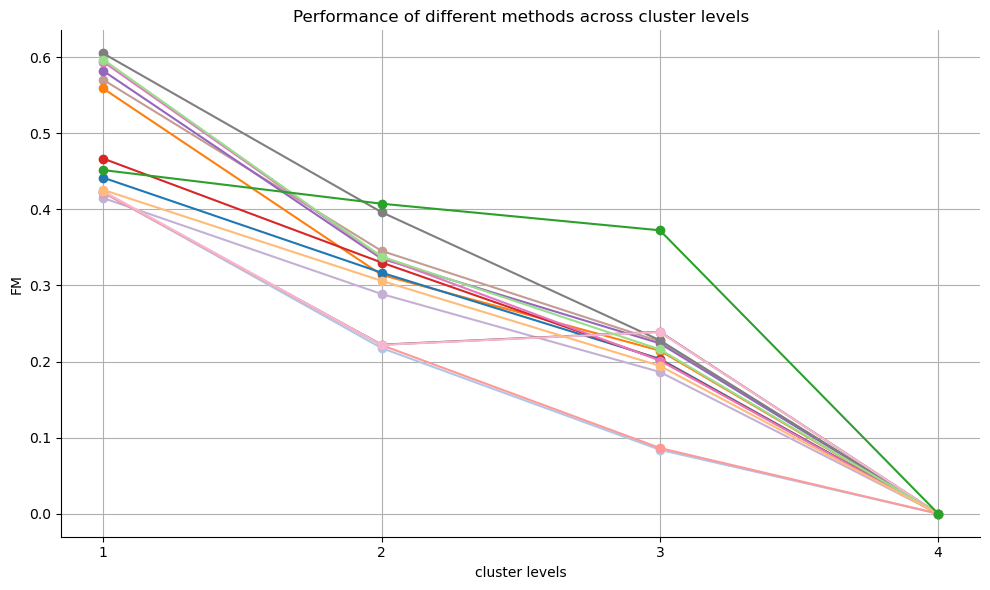

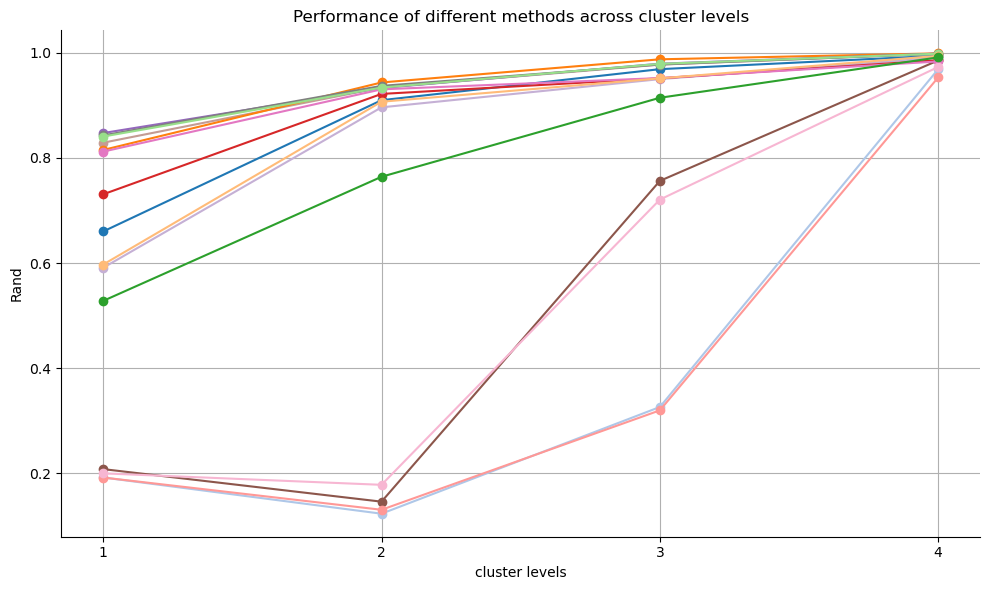

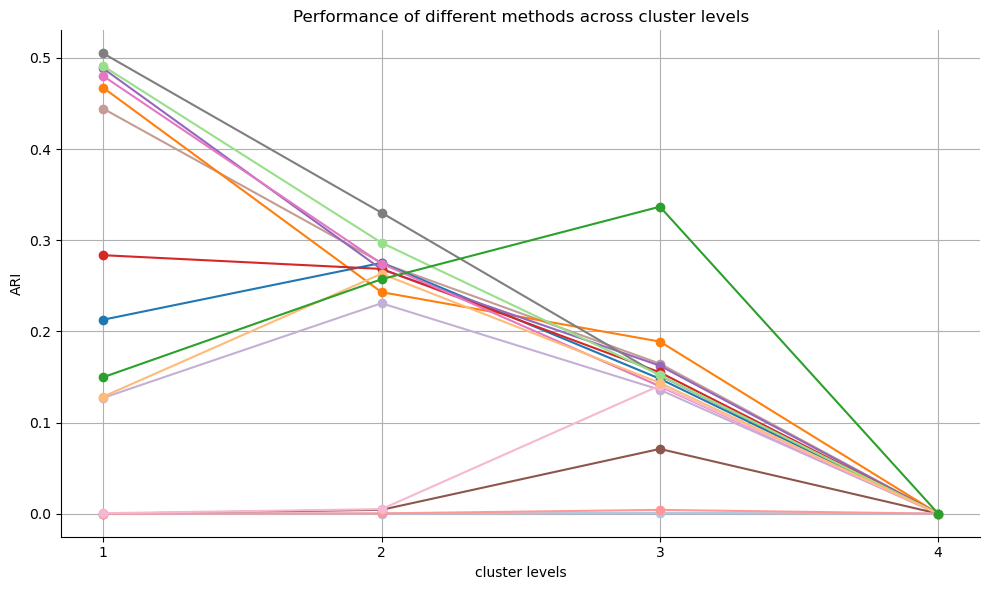

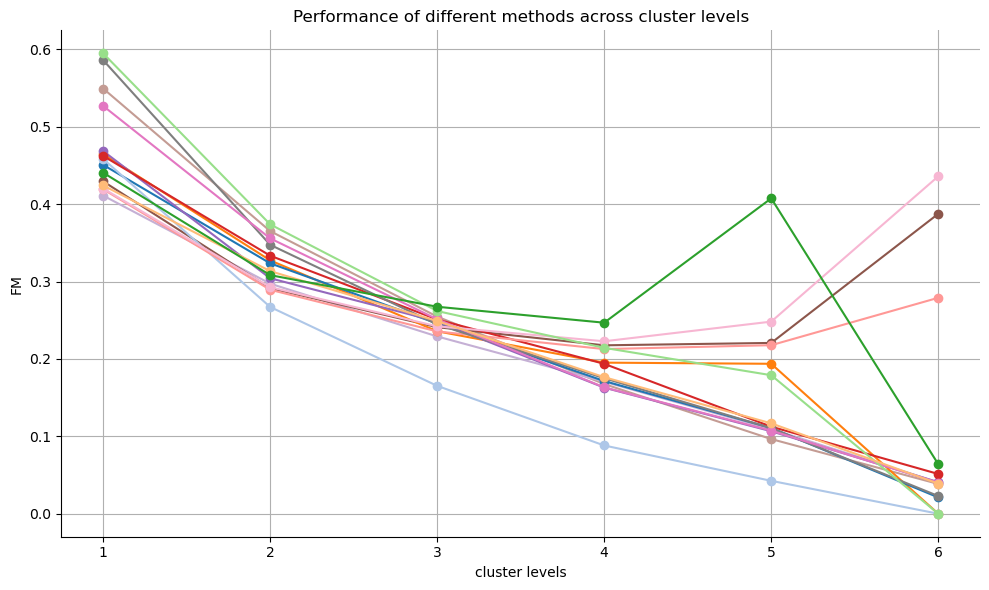

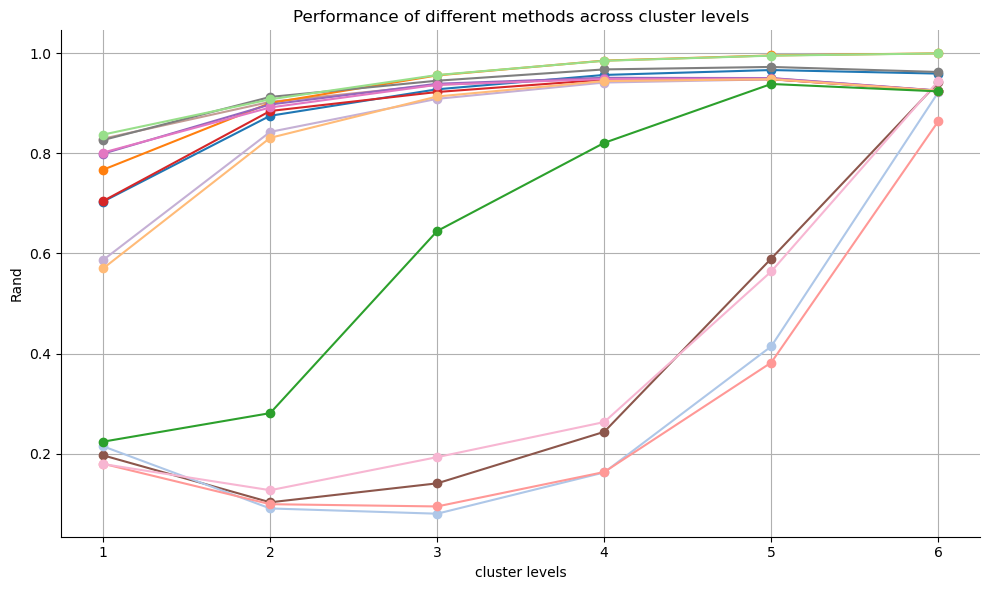

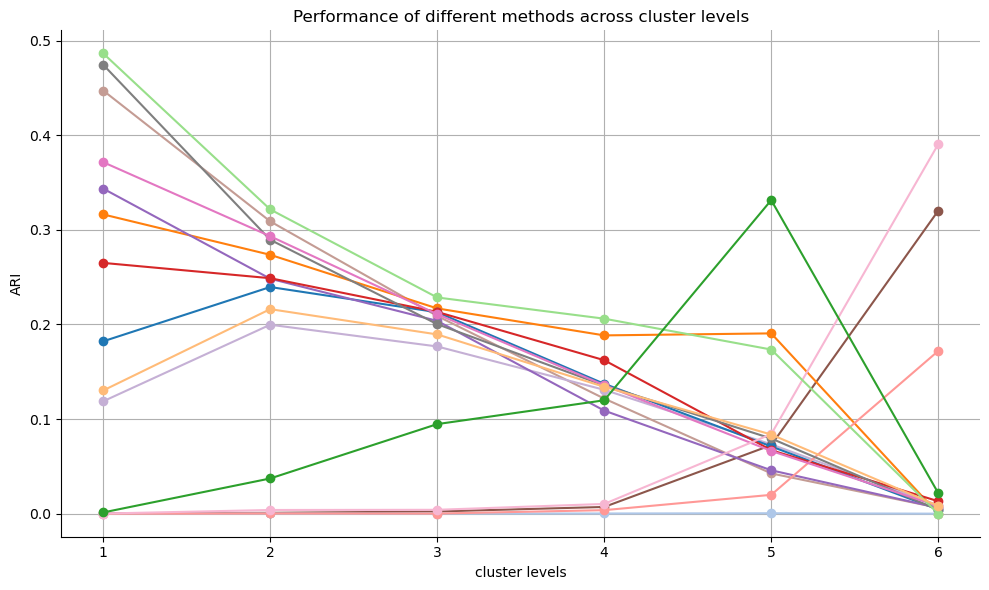

In [8]:

for param_lst in params:
    theme =param_lst['theme']
    t=param_lst['t']
    maxsub =param_lst['maxsub']
    depth =param_lst['depth']
    synonyms =param_lst['synonyms']
    branching = param_lst['']
    noise = param_lst['noise']


    if None not in param_lst.values():
        bertopic_file = f'{embedding}_results/results_all_methods_{theme}_hierarchy_t{t}_maxsub{maxsub}_depth{depth}_synonyms{synonyms}_noise{noise}_{branching}.csv'

    else:
        file_string = "processed_results"
        for key,val in param_lst.items():
            if val is not None:
                if key != 'theme':
                    file_string += f'_{key}{val}'
                else:
                    file_string +=f'_{val}'
        file_string+='.csv'
        bertopic_file = f'{embedding}_results/'+file_string
                
    bertopic_results=pd.read_csv(bertopic_file)

    bertopic_results['reduction_method'] = bertopic_results['reduction_method'].fillna("None")
    score_numbers = bertopic_results['level'].unique()
    for score in ['FM','Rand','ARI']:
        df_results = bertopic_results.pivot_table(index=['reduction_method', 'cluster_method'], 
                                        columns='level', 
                                        values=[f'{score}'], 
                                        aggfunc='median')
        # os.makedirs(f'{embedding}_comparison_result_tables', exist_ok=True)
        os.makedirs(f'{embedding}_comparison_result_plots', exist_ok=True)

        # Reset the columns and index
        df_results.columns = [f'{col[0]}_level_{col[1]}' for col in df_results.columns]
        df_results.reset_index(inplace=True)

        # table_file  =f'{embedding}_comparison_result_tables/{score}_Comparison_{theme}_hierarchy_t{t}_maxsub{maxsub}_depth{depth}_noise{noise}_{branching}.csv'


        # df_results.to_csv(table_file)

        bk_columns = [col for col in df_results.columns if col.startswith(f'{score}_level')]
        

        # Initialize the plot
        plt.figure(figsize=(10, 6))

        # Plot each method's performance across BK levels
        colors = cycle(plt.cm.tab20.colors)  # This creates a color cycle from tab10 colormap

        x_labels = list(range(1, len(bk_columns) + 1))  # e.g., [1, 2, 3, 4, 5]

        for method in df_results['reduction_method'].unique():
            for cluster in df_results['cluster_method'].unique():
                subset = df_results[(df_results['reduction_method'] == method) & (df_results['cluster_method'] == cluster)]
                if not subset.empty:
                    performance = subset[bk_columns].values.flatten()
                    # print(np.mean(performance))
                    combo_key = f"{method}_{cluster}"
                    color = combo_color_map.get(combo_key, 'black')  # fallback to black if not found
                    plt.plot(x_labels, performance, marker='o', label=f'{method} - {cluster}', color=color)

        # Label axes
        plt.xlabel(f'cluster levels')  # x-axis is now numeric levels: 1, 2, 3, ...
        plt.ylabel(f'{score}')
        plt.title('Performance of different methods across cluster levels')

        # Set numeric ticks
        plt.xticks(ticks=x_labels, labels=[str(x) for x in x_labels])

        # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True,)

        # Remove upper and right spines
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.tight_layout()


        fig_file  =f'{embedding}_comparison_result_plots/{score}_plot_{theme}_hierarchy_t{t}_maxsub{maxsub}_depth{depth}_synonyms{synonyms}_noise{noise}_{branching}.png'
           
        plt.savefig(fig_file,transparent=True)


In [73]:


import matplotlib.pyplot as plt
from itertools import cycle

# Create a dummy figure just for the legend
fig, ax = plt.subplots(figsize=(6, 6))
lines = []
labels = []

# Use the same combo_color_map from your original script
for combo_key, color in combo_color_map.items():
    method, cluster = combo_key.split("_", 1)
    label = f"{method} - {cluster}"
    print(label)
    line, = ax.plot([], [], marker='o', color=color, label=label)
    lines.append(line)
    labels.append(label)

# Create the legend only
legend = ax.legend(handles=lines, labels=labels, loc='center', frameon=False)
ax.axis('off')  # Hide axes

# Save the legend figure
os.makedirs('legend_only_plots', exist_ok=True)
legend_file = f'legend_only_plots/legend_{theme}_t{t}_maxsub{maxsub}_depth{depth}_noise{noise}_{branching}.png'
fig.savefig(legend_file, dpi=300, bbox_inches='tight', transparent=True)
plt.close(fig)


None - Diffusion Condensation
None - HDBSCAN
None - Agglomerative
UMAP - Diffusion Condensation
UMAP - HDBSCAN
UMAP - Agglomerative
PCA - Diffusion Condensation
PCA - HDBSCAN
PCA - Agglomerative
BASE-PHATE - Diffusion Condensation
BASE-PHATE - HDBSCAN
BASE-PHATE - Agglomerative
PHATE - Diffusion Condensation
PHATE - HDBSCAN
PHATE - Agglomerative


Dropdown(description='Level:', options=(1, 2, 3, 4, 5, 6), value=1)

Button(description='Update Plot', style=ButtonStyle())

/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_97110/2645111134.py:21: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)
/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_97110/2645111134.py:21: UserWarning: The palette list has more values (20) than needed (15), which may not be intended.
  sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)


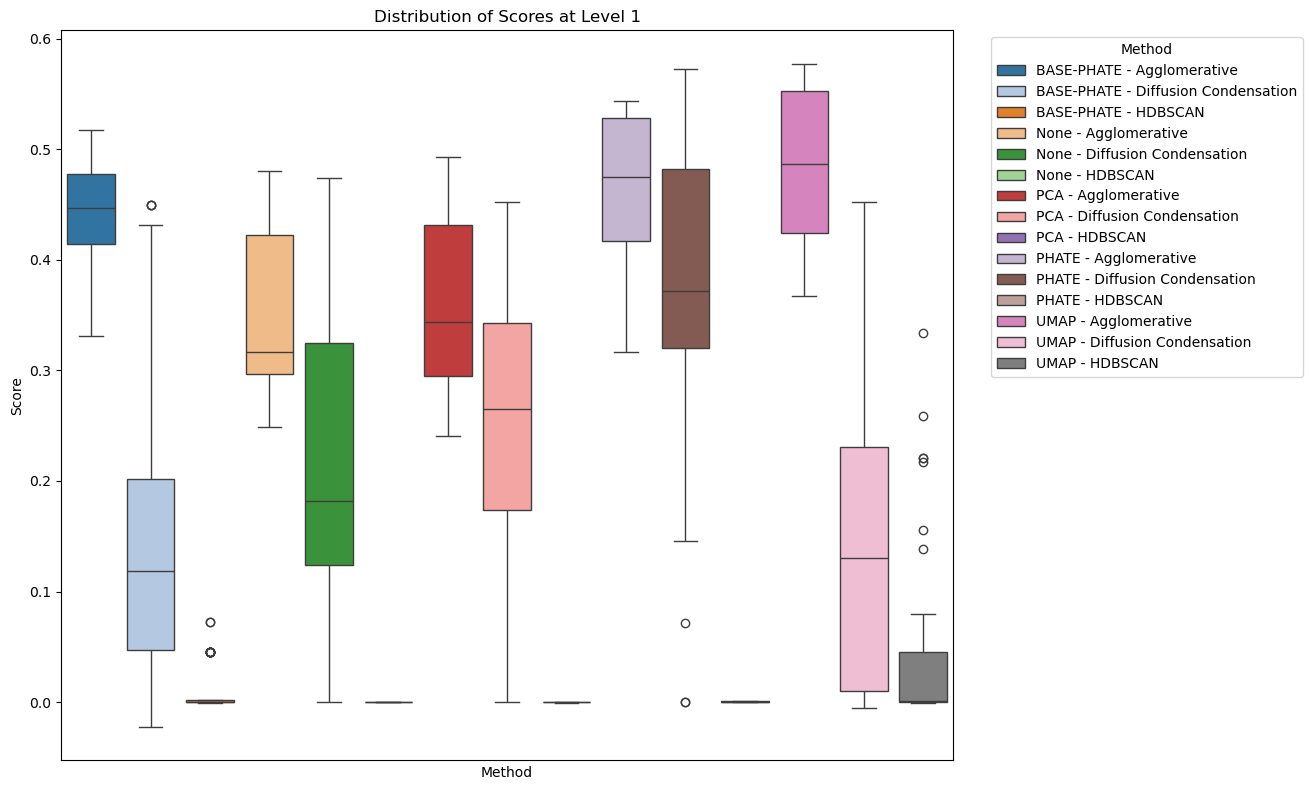

/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_97110/2645111134.py:21: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)
/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_97110/2645111134.py:21: UserWarning: The palette list has more values (20) than needed (15), which may not be intended.
  sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)


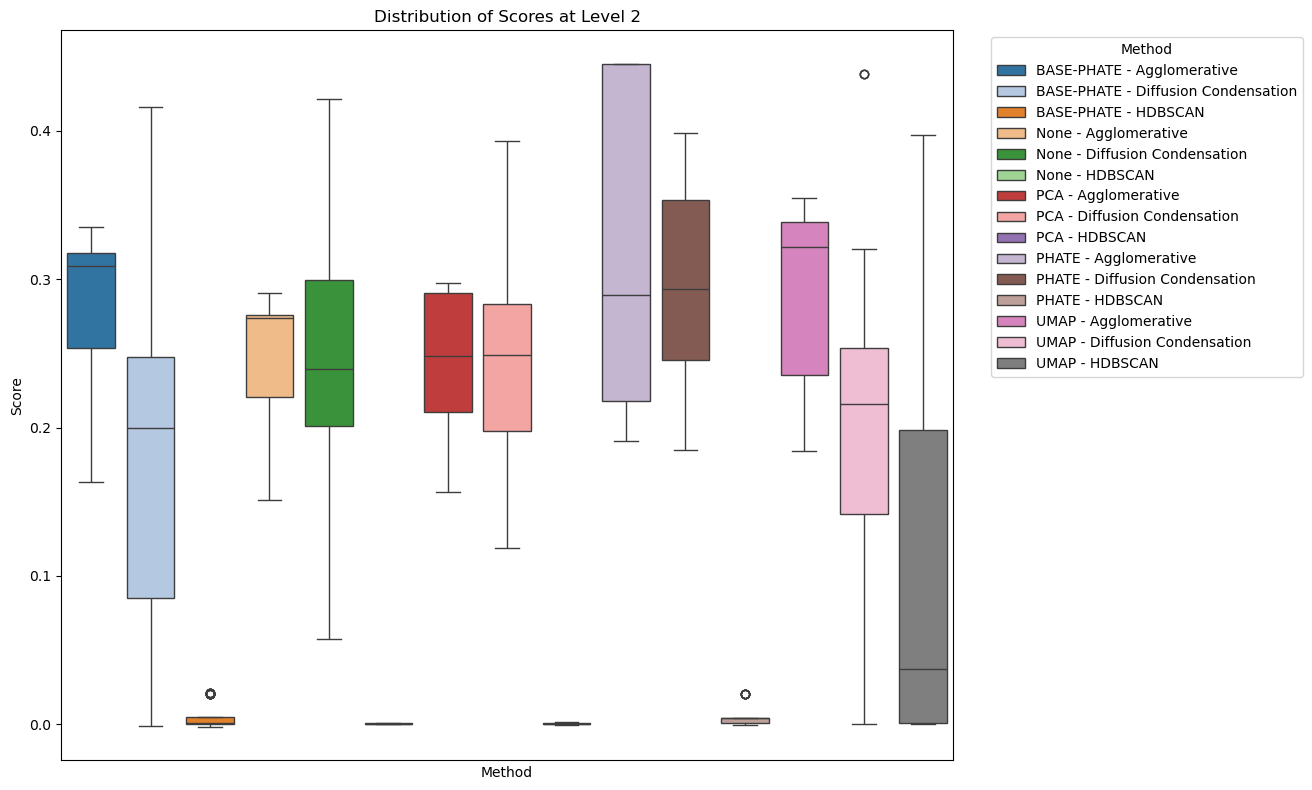

/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_97110/2645111134.py:21: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)
/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_97110/2645111134.py:21: UserWarning: The palette list has more values (20) than needed (15), which may not be intended.
  sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)


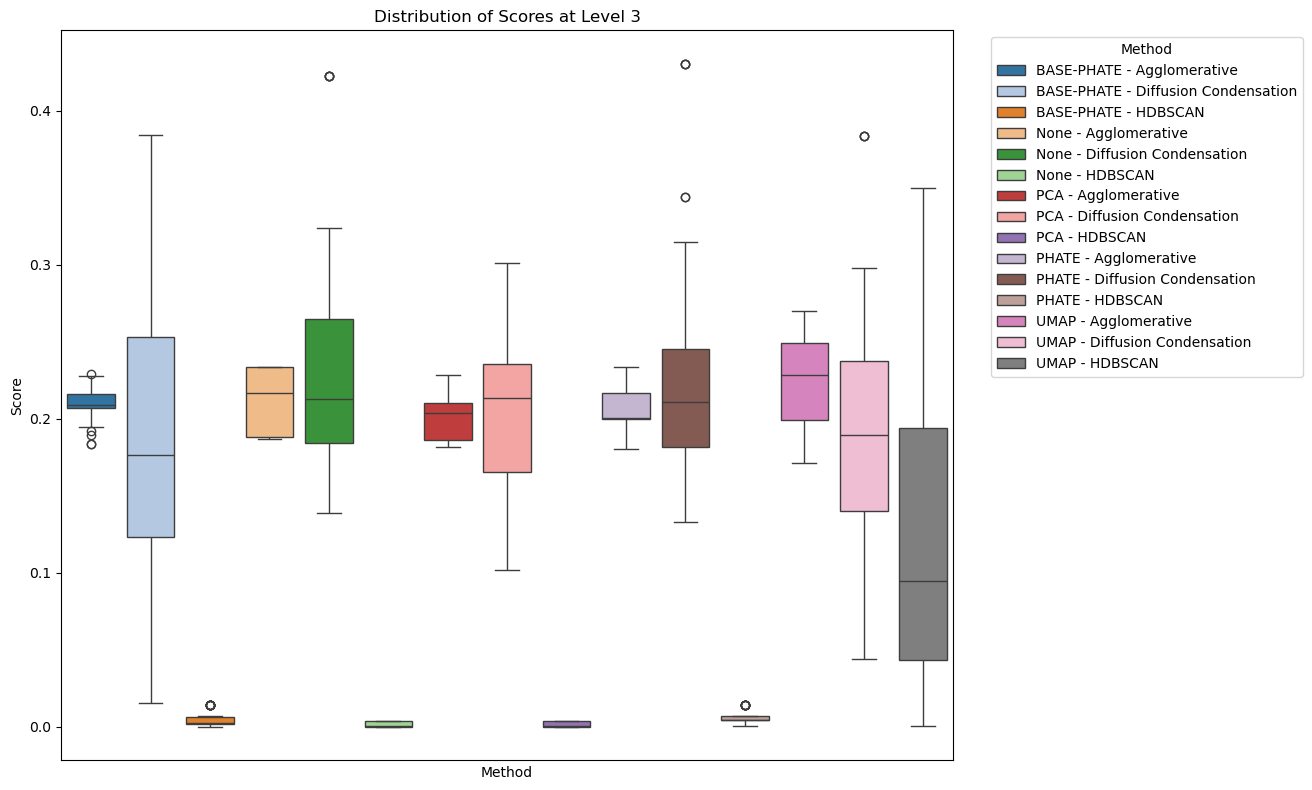

/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_97110/2645111134.py:21: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)
/var/folders/3z/trrz86kd2jjf4smrjx86v6k80000gp/T/ipykernel_97110/2645111134.py:21: UserWarning: The palette list has more values (20) than needed (15), which may not be intended.
  sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)


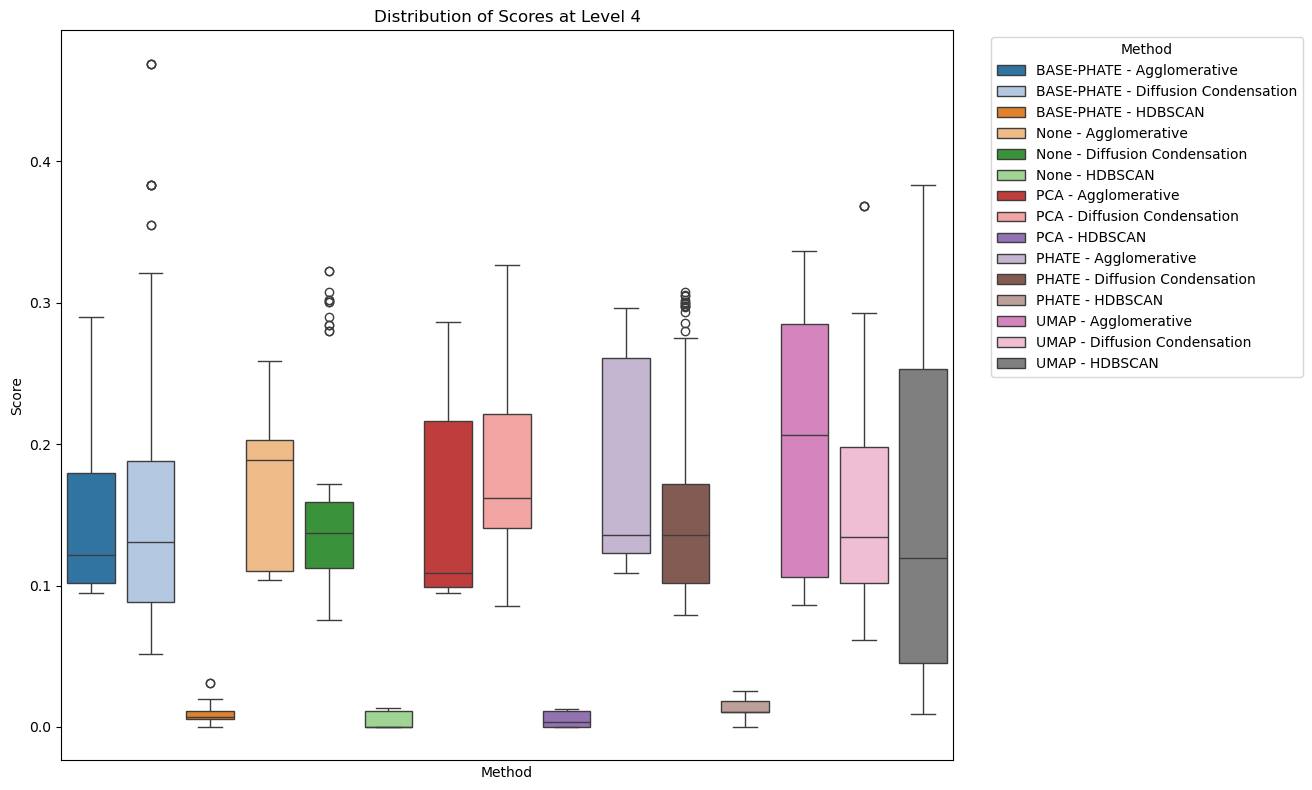

In [9]:

def update_plot(level):
    plt.figure(figsize=(14, 8))

    valid_subplots = 0  # Reset valid subplot counter
    # Filter the bertopic results for the selected level
    bertopic_subset = bertopic_results[bertopic_results['level'] == level]
    # Create a new column for plotting, combining bertopic and phate data
    bertopic_subset = bertopic_subset[['reduction_method', 'cluster_method', f'{score}']].dropna()
    bertopic_subset['Method'] = bertopic_subset['reduction_method'] + ' - ' + bertopic_subset['cluster_method']
    bertopic_subset = bertopic_subset.sort_values(by='Method')
    # Concatenate the two DataFrames for comparison
    bertopic_data = bertopic_subset[['Method', f'{score}']].rename(columns={f'{score}': 'Score'})

    # Skip plotting if more than 50% NaNs
    if bertopic_data['Score'].isna().sum() / len(bertopic_data) > 0.5:
        return

    valid_subplots += 1
    plt.subplot(1, valid_subplots, valid_subplots)
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    sns.boxplot(data=bertopic_data, x='Method', y='Score', hue='Method', palette=colors, legend=True)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), title='Method')
    plt.title(f'Distribution of Scores at Level {level}')
    plt.xticks([])
    plt.tight_layout()
    plt.show()

level_dropdown = widgets.Dropdown(
    options=bertopic_results['level'].unique(),
    description='Level:',
    value=score_numbers[0],  # Set the default value
)

update_button = widgets.Button(description="Update Plot")

def on_button_click(b):
    update_plot(level_dropdown.value)

update_button.on_click(on_button_click)

display(level_dropdown, update_button)

update_plot(level_dropdown.value)